# Spiking Rates for a model with 5 dense layers of equal neurons

## Initialize data

In [19]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
import tensorflow as tf
import nengo_dl
import copy

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [20]:
# obtain images
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.cifar10.load_data()

# normalize data by color channel
def normalize(array):
    return (array - np.mean(array)) / np.std(array)

train_images_R = normalize(train_images.transpose()[0].transpose())
train_images_G = normalize(train_images.transpose()[1].transpose())
train_images_B = normalize(train_images.transpose()[2].transpose())
test_images_R = normalize(test_images.transpose()[0].transpose())
test_images_G = normalize(test_images.transpose()[1].transpose())
test_images_B = normalize(test_images.transpose()[2].transpose())

train_images = np.array([train_images_R, train_images_G, train_images_B])
test_images = np.array([test_images_R, test_images_G, test_images_B])

train_images = np.moveaxis(train_images, 0, -1)
test_images = np.moveaxis(test_images, 0, -1)

# verify normalization
print((train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape))
print('test mean:', np.mean(train_images))
print('test stdv:', np.std(train_images))
print('train mean:', np.mean(test_images))
print('train stdv:', np.std(test_images))

((50000, 32, 32, 3), (50000, 1)) ((10000, 32, 32, 3), (10000, 1))
test mean: 5.4830214442821065e-17
test stdv: 1.0000000000000002
train mean: 8.14903700074865e-18
train stdv: 1.0000000000000002


In [21]:
# flatten images and add time dimension
train_images = train_images.reshape((train_images.shape[0], 1, -1))
train_labels = train_labels.reshape((train_labels.shape[0], 1, -1))
test_images = test_images.reshape((test_images.shape[0], 1, -1))
test_labels = test_labels.reshape((test_labels.shape[0], 1, -1))

print((train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape))

((50000, 1, 3072), (50000, 1, 1)) ((10000, 1, 3072), (10000, 1, 1))


## Build network and convert to nengo-dl

In [22]:
inp = tf.keras.Input(shape=(32, 32, 3))

flatten = tf.keras.layers.Flatten()(inp)

# reduced to 200 neurons per layer (75 was too low)
dense0 = tf.keras.layers.Dense(units=204, activation=tf.nn.relu, name='d0')(flatten)
dense1 = tf.keras.layers.Dense(units=203, activation=tf.nn.relu, name='d1')(dense0)
dense2 = tf.keras.layers.Dense(units=202, activation=tf.nn.relu, name='d2')(dense1)
dense3 = tf.keras.layers.Dense(units=201, activation=tf.nn.relu, name='d3')(dense2)
dense4 = tf.keras.layers.Dense(units=200, activation=tf.nn.relu, name='d4')(dense3)

out = tf.keras.layers.Dense(units=10)(dense4)

model = tf.keras.Model(inputs=inp, outputs=out)

In [23]:
converter = nengo_dl.Converter(model)

## Train the non-spiking network

In [61]:
with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
    
    sim.compile(
        optimizer=tf.optimizers.Adam(0.001),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.sparse_categorical_accuracy]
    )

    sim.fit(
        {converter.inputs[inp]: train_images},
        {converter.outputs[out]: train_labels},
        validation_data=({converter.inputs[inp]: test_images}, {converter.outputs[out]: test_labels}),
        epochs=20
    )

    # save the parameters
    sim.save_params("./3_conv_params")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/20
250/250 [==============================] - 39s 79ms/step - loss: 1.8004 - probe_loss: 1.8004 - probe_sparse_categorical_accuracy: 0.3441 - val_loss: 1.3571 - val_probe_loss: 1.3571 - val_probe_sparse_categorical_accuracy: 0.5067
Epoch 2/20
250/250 [==============================] - 19s 76ms/step - loss: 1.3209 - probe_loss: 1.3209 - probe_sparse_categorical_accuracy: 0.5270 - val_loss: 1.2044 - val_probe_loss: 1.2044 - val_probe_sparse_categorical_accuracy: 0.5704
Epoch 3/20
250/250 [==============================] - 22s 86ms/step - loss: 1.1490 - probe_loss: 1.1490 - probe_sparse_categorical_accuracy: 0.5938 - val_loss: 1.0642 - val_probe_loss: 1.0642 - val_probe_sparse_categorical_accuracy: 0.6231
Epoch 4/20
250/250 [====================

## Run the non-spiking network

In [24]:
probed_layers = [dense0, dense1, dense2, dense3, dense4]

probed_layer_to_model_layer_dict = {
    inp.ref(): model.layers[0],
    dense0.ref(): model.layers[2],
    dense1.ref(): model.layers[3],
    dense2.ref(): model.layers[4],
    dense3.ref(): model.layers[5],
    dense4.ref(): model.layers[6],
    out.ref(): model.layers[7],
}

In [25]:
def run_network(
    activation,
    params_file="equal_dnn_params",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=400,
    n_images_for_rates=1,
    n_sample_neurons=100,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse=synapse,
    )

    # get input/output objects
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[out]

    # add a probe to the first convolutional layer to record activity.
    # we'll only record from a subset of neurons, to save memory.
    sample_neurons = np.array([
        np.linspace(0, np.prod(layer.shape[1:]), n_sample_neurons, endpoint=False, dtype=np.int32) for layer in probed_layers
    ])

    # set probes
    with nengo_converter.net:
        probes = np.array([
            nengo.Probe(nengo_converter.layers[probed_layers[l]][sample_neurons[l]]) for l in range(len(probed_layers))
        ])

    probe_to_model_layer_dict = { probes[l]: probed_layer_to_model_layer_dict[probed_layers[l].ref()] for l in range(len(probed_layers)) }

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(test_images[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(nengo_converter.net, minibatch_size=200, progress_bar=False) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    accuracy = (predictions == test_labels[:n_test, 0, 0]).mean()
    print(f" test accuracy: {100 * accuracy:.2f}%")

    rates_for_images = []
    for image in range(n_images_for_rates):
        if isinstance(scale_firing_rates, dict):
            scaled_data = np.array([
                data[probe][image] * scale_firing_rates[probe_to_model_layer_dict[probe]] for probe in probes
            ])
        else:
            scaled_data = np.array([
                data[probe][image] * scale_firing_rates for probe in probes
            ])
                
        if isinstance(activation, nengo.SpikingRectifiedLinear) or isinstance(activation, nengo.LIF):
            scaled_data /= n_sample_neurons
            layer_rates = np.array([
                np.sum(scaled_data[i], axis=0) / (n_steps * nengo_sim.dt) for i in range(len(scaled_data))
            ])
        else:
            layer_rates = scaled_data

        rates_for_images.append(layer_rates)
       
    avg_layer_rates = np.mean(np.array(rates_for_images), axis=0)

    return (accuracy, avg_layer_rates)

In [26]:
baseline_accuracy, baseline_rates = run_network(activation=nengo.RectifiedLinear(), n_steps=10)

 test accuracy: 53.00%


In [40]:
n_steps=60
synapse=0.01
scale_firing_rates=50
n_images_for_rates=100
n_sample_neurons=200

spiking_accuracy, spiking_rates = run_network(
        activation=nengo.SpikingRectifiedLinear(), 
        n_steps=n_steps, 
        synapse=synapse, 
        scale_firing_rates=scale_firing_rates,
        n_images_for_rates=n_images_for_rates,
        n_sample_neurons=n_sample_neurons,
    )

 test accuracy: 47.00%


In [55]:
rate_data.shape

(5, 200)

In [68]:
spiking_rates[0].shape

(200,)

In [115]:
# create plots of layer rates
import seaborn as sns
sns.set_style("white")
for l in range(len(spiking_rates)):
    rate_data = spiking_rates[l]

    plt.xlabel("Firing Rate (Hz)")
    plt.ylabel("Relative Neuron Count")
    plt.title("Firing Rate Distribution in SNN (Acc.=" + str(spiking_accuracy) + ")\n(synapse="+str(synapse)+", scale_firing_rates="+str(scale_firing_rates)+", DNN="+str(baseline_accuracy)+")")
    labels = ['dense0', 'dense1', 'dense2', 'dense3', 'dense4']

    kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':2})
    
    # for l in rate_data:
    s = sns.distplot(rate_data, bins=20, label=labels[l], color=sns.color_palette()[l], **kwargs)
    s.legend()
    plt.savefig("./images/individual_layer_"+str(l)+"_bar_spiking_rates_"+str(n_images_for_rates)+"im_"+str(synapse)[2:]+"_"+str(scale_firing_rates)+"_neurons="+str(n_sample_neurons), dpi=300)
    plt.close()

C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:

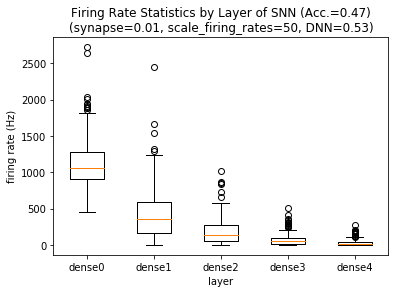

In [66]:
# create plots of layer rates
rate_data = spiking_rates.swapaxes(0, 1)

plt.xlabel("layer")
plt.ylabel("firing rate (Hz)")
plt.title("Firing Rate Statistics by Layer of SNN (Acc.=" + str(spiking_accuracy) + ")\n(synapse="+str(synapse)+", scale_firing_rates="+str(scale_firing_rates)+", DNN="+str(baseline_accuracy)+")")

labels = ['dense0', 'dense1', 'dense2', 'dense3', 'dense4']
plt.boxplot(rate_data, labels=labels, showfliers=True)
plt.savefig("./images/spiking_rates_"+str(n_images_for_rates)+"im_"+str(synapse)[2:]+"_"+str(scale_firing_rates)+"_neurons="+str(n_sample_neurons), dpi=300)